# Detecting Dataset Drift with whylogs

We will be using data from Kaggle (https://www.kaggle.com/yugagrawal95/sample-media-spends-data) that is packaged with this notebook.

In [1]:
%matplotlib inline
!pip install seaborn
import datetime
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from whylogs import get_or_create_session

In [2]:
# Read our Media Spend dataset as Pandas dataframe
data = pd.read_csv("data/sample_media_spend.csv",
                   parse_dates=["Calendar_Week"], infer_datetime_format=True)

In [3]:
data

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
0,A,2018-01-06,392,422,408,3.498950e+05,73580,12072,682,59417
1,A,2018-01-13,787,904,110,5.062702e+05,11804,9499,853,56806
2,A,2018-01-20,81,970,742,4.300422e+05,52232,17048,759,48715
3,A,2018-01-27,25,575,65,4.177457e+05,78640,10207,942,72047
4,A,2018-02-03,565,284,295,4.085058e+05,40561,5834,658,56235
...,...,...,...,...,...,...,...,...,...,...
3046,Z,2020-02-01,29239,25311,622406,1.459071e+06,45026,12098,53667,82707
3047,Z,2020-02-08,26230,28031,624409,5.342505e+05,227070,9548,53665,84503
3048,Z,2020-02-15,24749,31281,439362,4.227182e+05,393685,9861,55561,147325
3049,Z,2020-02-22,20713,30356,464178,6.085799e+05,424676,10221,49221,111525


As we can see here, we have advertising and media impressions and views per week for a number of marketing campaigns for some unknown company. Included with this information is sales against those spends.

## Exploratory Data Analysis

Let's now explore the dataset; we have very little metadata or context.

In [4]:
data.groupby("Calendar_Week").count().T

Calendar_Week,2018-01-06,2018-01-13,2018-01-20,2018-01-27,2018-02-03,2018-02-10,2018-02-17,2018-02-24,2018-03-03,2018-03-10,...,2019-12-28,2020-01-04,2020-01-11,2020-01-18,2020-01-25,2020-02-01,2020-02-08,2020-02-15,2020-02-22,2020-02-29
Division,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Paid_Views,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Organic_Views,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Google_Impressions,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Email_Impressions,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Facebook_Impressions,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Affiliate_Impressions,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Overall_Views,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Sales,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27


In [5]:
data.groupby("Division").count().T

Division,A,B,C,D,E,F,G,H,I,J,...,Q,R,S,T,U,V,W,X,Y,Z
Calendar_Week,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Paid_Views,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Organic_Views,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Google_Impressions,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Email_Impressions,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Facebook_Impressions,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Affiliate_Impressions,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Overall_Views,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226
Sales,113,113,113,113,113,113,113,113,113,113,...,113,113,113,113,113,113,113,113,113,226


We see that the *Z* division has double the entries than the other divisions.

<AxesSubplot:xlabel='Calendar_Week', ylabel='Sales'>

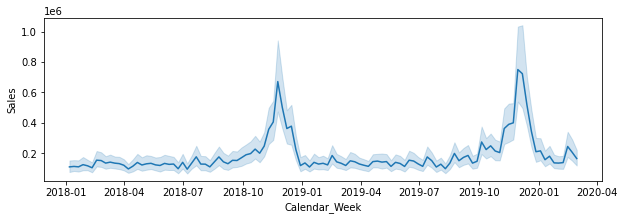

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(x="Calendar_Week", y="Sales", data=data, ax=ax)

<AxesSubplot:xlabel='Google_Impressions', ylabel='Sales'>

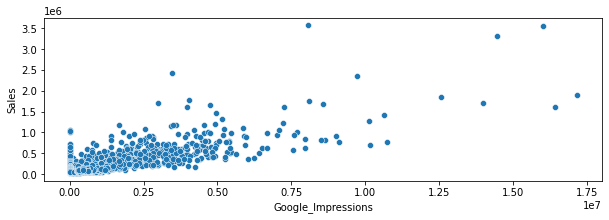

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(x="Google_Impressions", y="Sales", data=data, ax=ax)

Let's compare the data from the first month to the last month, which happens to capture differences in transactions prior to and during the COVID-19 global pandemic.

## Profiling with whylogs

In [8]:
model_date = datetime.datetime(2020, 1, 1)
training_data = data[data["Calendar_Week"] < model_date]
test_data = data[data["Calendar_Week"] >= model_date]

In [9]:
session = get_or_create_session()

In [10]:
profiles = []
profiles.append(session.log_dataframe(training_data, dataset_timestamp=model_date))
profiles.append(session.log_dataframe(test_data, dataset_timestamp=datetime.datetime.now()))

In [11]:
profiles

We can compare the data we'll use for training with that in early 2020.

In [12]:
# Training data profile summary
training_summary = profiles[0].flat_summary()["summary"]
training_summary

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,nunique_str_upper,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,Paid_Views,2808.0,0.0,0.0,2808.0,5.181900e+05,13424.596510,1.00000,2.974463e+04,2111.0,...,0.0,1.000000,16.000000,121.000000,497.00000,984.00,1.439500e+04,58627.000,147847.0,518190.0
1,Google_Impressions,2808.0,0.0,0.0,2808.0,1.715044e+07,898847.349715,7.00000,1.391820e+06,2678.0,...,0.0,7.000000,65.000000,260.000000,160499.00000,489114.00,1.049125e+06,3407128.000,7063965.0,17150440.0
2,Email_Impressions,2808.0,0.0,0.0,2808.0,5.160764e+06,755149.145825,40894.44732,6.095038e+05,2808.0,...,0.0,40894.449219,74191.007812,134665.640625,379029.78125,591719.75,9.552447e+05,1886981.625,3151602.0,5160763.5
3,Overall_Views,2808.0,0.0,0.0,2808.0,6.350570e+05,24357.878561,2.00000,4.901499e+04,2360.0,...,0.0,2.000000,19.000000,153.000000,691.00000,5369.00,2.707700e+04,103070.000,220514.0,635057.0
4,Calendar_Week,2808.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.00000,0.000000e+00,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Division,2808.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.00000,0.000000e+00,0.0,...,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Organic_Views,2808.0,0.0,0.0,2808.0,2.704530e+05,11406.093305,1.00000,2.218563e+04,2316.0,...,0.0,1.000000,22.000000,128.000000,665.00000,3098.00,1.301400e+04,47060.000,104016.0,270453.0
7,Facebook_Impressions,2808.0,0.0,0.0,2808.0,7.558435e+06,269330.694088,29.00000,4.800746e+05,2793.0,...,0.0,29.000000,4147.000000,12747.000000,55115.00000,121568.00,2.737920e+05,1029754.000,2407679.0,7558435.0
8,Sales,2808.0,0.0,0.0,2808.0,3.575430e+06,186838.814459,15436.00000,2.372908e+05,2788.0,...,0.0,15436.000000,25369.000000,44469.000000,72504.00000,112703.00,2.043080e+05,591908.000,1065250.0,3575430.0
9,Affiliate_Impressions,2808.0,0.0,0.0,2808.0,1.757910e+05,23426.283476,910.00000,2.198081e+04,2715.0,...,0.0,910.000000,1689.000000,3366.000000,9279.00000,17072.00,2.864900e+04,70103.000,114238.0,175791.0


In [13]:
# Test data profile summary
test_summary = profiles[1].flat_summary()["summary"]
test_summary

,column,count,null_count,bool_count,numeric_count,max,mean,min,stddev,nunique_numbers,...,nunique_str_upper,quantile_0.0000,quantile_0.0100,quantile_0.0500,quantile_0.2500,quantile_0.5000,quantile_0.7500,quantile_0.9500,quantile_0.9900,quantile_1.0000
0,Email_Impressions,243.0,0.0,0.0,243.0,7317730.249,822449.835680,61334.57103,791161.059026,243.0,...,0.0,61334.570312,65779.898438,137562.171875,387119.625,580975.6875,997442.8125,2390848.0,3884578.75,7317730.0
1,Google_Impressions,243.0,0.0,0.0,243.0,4924815.000,739724.279835,156.00000,806022.000918,243.0,...,0.0,156.000000,196.000000,531.000000,274410.000,504923.0000,926291.0000,2542278.0,4304549.00,4924815.0
2,Facebook_Impressions,243.0,0.0,0.0,243.0,1884146.000,266771.794239,6987.00000,263839.011975,243.0,...,0.0,6987.000000,13480.000000,33168.000000,103418.000,180094.0000,331702.0000,792423.0,1073992.00,1884146.0
3,Sales,243.0,0.0,0.0,243.0,1181536.000,175069.012346,23012.00000,162280.683991,243.0,...,0.0,23012.000000,25043.000000,48057.000000,86953.000,124325.0000,206752.0000,430355.0,968892.00,1181536.0
4,Calendar_Week,243.0,0.0,0.0,0.0,0.000,0.000000,0.00000,0.000000,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Division,243.0,0.0,0.0,0.0,0.000,0.000000,0.00000,0.000000,0.0,...,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Paid_Views,243.0,0.0,0.0,243.0,195738.000,34384.152263,374.00000,35731.933116,242.0,...,0.0,374.000000,1033.000000,4106.000000,13171.000,23623.0000,41052.0000,118075.0,183982.00,195738.0
7,Affiliate_Impressions,243.0,0.0,0.0,243.0,79685.000,16955.390947,1139.00000,15712.996483,241.0,...,0.0,1139.000000,1529.000000,2498.000000,7719.000,12525.0000,20478.0000,59464.0,74730.00,79685.0
8,Overall_Views,243.0,0.0,0.0,243.0,381029.000,69847.102881,2767.00000,66124.495307,243.0,...,0.0,2767.000000,2934.000000,12456.000000,31996.000,49221.0000,82206.0000,227079.0,337803.00,381029.0
9,Organic_Views,243.0,0.0,0.0,243.0,198041.000,35884.152263,1917.00000,32322.531757,242.0,...,0.0,1917.000000,2064.000000,7516.000000,17112.000,26315.0000,44050.0000,104290.0,173100.00,198041.0


## Dataset Drift in whylogs Data

We need to understand how the data changes between that used in training and test data. To do so, let's first view one of the many objects in the dataset profile provided by whylogs, a histogram for each feature tracked. We can then inspect the **Overall_Views** feature.

In [14]:
training_histograms = profiles[0].flat_summary()["hist"]
test_histograms = profiles[1].flat_summary()["hist"]

test_histograms["Overall_Views"]

{'bin_edges': [2767.0,
  15375.73460343,
  27984.46920686,
  40593.203810290004,
  53201.93841372,
  65810.67301715,
  78419.40762058001,
  91028.14222401001,
  103636.87682744,
  116245.61143087,
  128854.3460343,
  141463.08063773002,
  154071.81524116002,
  166680.54984459002,
  179289.28444802001,
  191898.01905145,
  204506.75365488,
  217115.48825831,
  229724.22286174,
  242332.95746517,
  254941.6920686,
  267550.42667203,
  280159.16127546004,
  292767.89587889,
  305376.63048232003,
  317985.36508575,
  330594.09968918003,
  343202.83429261,
  355811.56889604003,
  368420.30349947,
  381029.0381029],
 'counts': [17,
  32,
  42,
  40,
  26,
  18,
  15,
  13,
  8,
  3,
  5,
  7,
  0,
  0,
  1,
  2,
  0,
  2,
  0,
  3,
  1,
  1,
  2,
  0,
  1,
  0,
  2,
  1,
  0,
  1]}

While we plan to integrate convienient dataset shift visualization and analysis API soon, you are always able to access the attributes you need.

We will first define a custom range and bins, then utilize our access to the data sketches' probability mass function. We then visualize these values using Seaborn.

In [15]:
def get_custom_histogram_info(variable, n_bins):
    min_range = min(training_summary[training_summary["column"]==variable]["min"].values[0],
                    test_summary[test_summary["column"]==variable]["min"].values[0])
    max_range = max(training_summary[training_summary["column"]==variable]["max"].values[0],
                    test_summary[test_summary["column"]==variable]["max"].values[0])
    bins = range(int(min_range), int(max_range), int((max_range-min_range)/n_bins))

    training_counts = np.array(
        profiles[0].columns[variable].number_tracker.histogram.get_pmf(bins[:-1]))
    test_counts = np.array(
        profiles[1].columns[variable].number_tracker.histogram.get_pmf(bins[:-1]))
    
    return bins, training_counts, test_counts


def plot_distribution_shift(variable, n_bins):
    """Visualization for distribution shift"""
    bins, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)

    fig, ax = plt.subplots(figsize=(10, 3))
    sns.histplot(x=bins, weights=training_counts, bins=n_bins, 
                 label="Training data", color="teal", alpha=0.7, ax=ax)
    sns.histplot(x=bins, weights=test_counts, bins=n_bins, 
                 label="Test data", color="gold", alpha=0.7, ax=ax)
    ax.legend()
    plt.show()

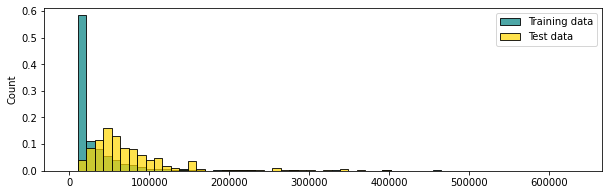

In [16]:
plot_distribution_shift("Overall_Views", n_bins=60)

While it is quite clear that the distribution in this case differs between the training and test dataset, we will likely need a quantitative measure. You can also use whylogs histogram metrics to calculate dataset shift using a number of metrics: Population Stability Index (PSI), Kolmogorov-Smirnov statistic, Kullback-Lebler divergence (or other f-divergences), and histogram intersection.

## Kullback-Lebler divergence

This score, often shortened to K-L divergence, is measure of how one probability distribution is different from a second, reference probability distribution. The K-L divergence can be interpreted as the average difference of the number of bits required for encoding samples of one distribution (*P*) using a code optimized for another (*Q*) rather than one optimized for *P*. KL divergence is not a true statistical metric of spread as it is not symmetric and does not satisfy the triangle inequality.

However, this value has become quite poplular and easy to calculate in Python. We'll use the implementation in `scikit-learn`.

In [17]:
from sklearn.metrics import mutual_info_score
    
def calculate_kl_divergence(variable, n_bins):
    _, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)
    
    return mutual_info_score(training_counts, test_counts)

In [18]:
calculate_kl_divergence("Overall_Views", n_bins=60)

1.0517181609494641

## Histogram intersection metric

Our second metric is the histogram intersection score, which is an intuitive metric that measures the area of overlap between the two probability distributions. A histogram intersection score of 0.0 represents no overlap while a score of 1.0 represents identical distributions. This score requires discretized probability distributions and depends heavily on the choice of bin size and scale used.

In [19]:
def calculate_histogram_intersection(variable, n_bins):
    _, training_counts, test_counts = get_custom_histogram_info(variable, n_bins)
    
    result = 0
    for i in range(n_bins):
        result += min(training_counts[i], test_counts[i])
    return result

In [20]:
calculate_histogram_intersection("Overall_Views", n_bins=60)

0.4246201329534663

In [21]:
calculate_histogram_intersection("Sales", n_bins=60)

0.8393874643874643